# Centering Images

## Setup

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import nibabel as nb
from nilearn import plotting

In [3]:
from scipy import ndimage

In [4]:
# DATA_DIR = 'data/BL'
DATA_DIR = 'data/FUP'

## Load lumen mask

In [5]:
file_identifier = '04902d9c93854537b8424e8ba34ae660'

In [6]:
lumen = nb.load(os.path.join(DATA_DIR, f'{file_identifier}_reorient-lumen.nii.gz'))

In [7]:
lumen_np = np.asanyarray(lumen.dataobj)

In [8]:
lumen_np.shape

(512, 512, 541)

## Centering

In [9]:
def find_centroid(image):
    ys, xs = np.where(image)
    x_min, x_max = xs.min(), xs.max()
    y_min, y_max = ys.min(), ys.max()

    x_c = (x_min + x_max) // 2
    y_c = (y_min + y_max) // 2

    return y_c, x_c

In [10]:
def find_centroid(image):
    y_c, x_c = ndimage.center_of_mass(image)
    return int(y_c), int(x_c)

In [11]:
def translate_image(image, dy, dx):
    translated = np.roll(image, dy, axis=0)
    translated = np.roll(translated, dx, axis=1)
    return translated

In [12]:
def translate_image_seq(image_seq, dy_seq, dx_seq):
    translated_seq = np.stack(
        [translate_image(image_seq[:, :, i], dy[i], dx[i]) for i in range(image_seq.shape[2])],
        axis=2
    )

    return translated_seq

In [13]:
def center_image(image_seq):
    y_c, x_c = np.array([find_centroid(image_seq[:, :, i]) for i in range(image_seq.shape[2])]).T
    y_c_im, x_c_im = image_seq.shape[0] // 2, image_seq.shape[1] // 2

    dx = x_c_im - x_c
    dy = y_c_im - y_c

    translated_seq = np.stack(
        [translate_image(image_seq[:, :, i], dy[i], dx[i]) for i in range(image_seq.shape[2])],
        axis=-1
    )

    return translated_seq, dy, dx

In [14]:
centered_lumen, dy, dx = center_image(lumen_np)

**Centered**

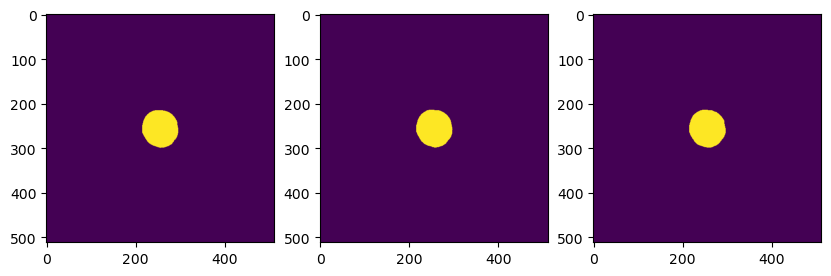

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(10, 15))

for i, ax in enumerate(ax):
    ax.imshow(centered_lumen[:, :, i])

**Original**

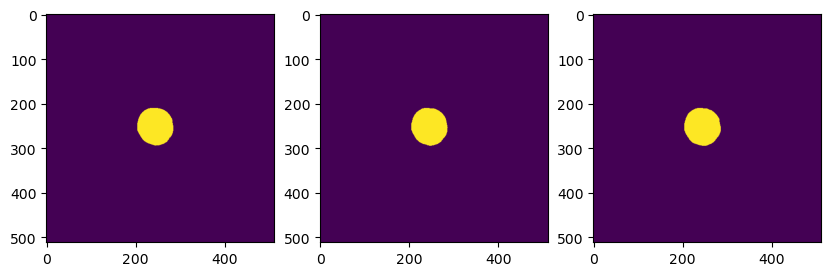

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(10, 15))

for i, ax in enumerate(ax):
    ax.imshow(lumen_np[:, :, i])

## Resizing

In [17]:
def repeat_resize(image, factor_y=2, factor_x=2):
    res = image.repeat(factor_y, axis=0)
    return res.repeat(factor_x, axis=1)

In [18]:
centered_res = np.stack(
    [repeat_resize(centered_lumen[:,:,i]) for i in range(lumen_np.shape[2])],
    axis=-1
)

In [19]:
centered_res.shape

(1024, 1024, 541)

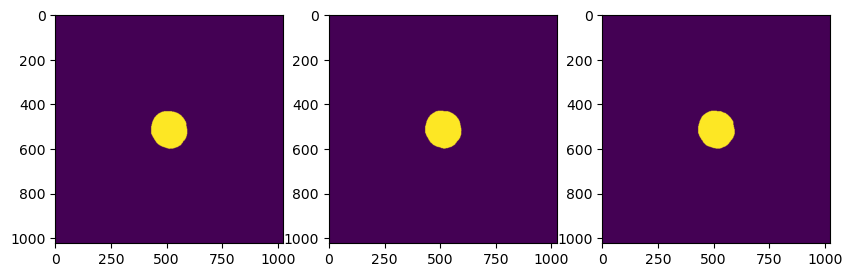

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(10, 15))

for i, ax in enumerate(axes):
    ax.imshow(centered_res[:, :, i])

## Apply to all masks

Stop our laptops crashing!!

In [21]:
del centered_res
del centered_lumen
del lumen
del lumen_np

In [22]:
mask_files = [x for x in os.listdir(DATA_DIR) if x.startswith(file_identifier)]

In [23]:
for f in mask_files:
    print(f"Processing {f}")
    f_full = os.path.join(DATA_DIR, f)
    
    try:
        nb_obj = nb.load(f_full)
        mask_np = np.asanyarray(nb_obj.dataobj)
        translated_mask = translate_image_seq(mask_np, dy, dx)
        res_mask = repeat_resize(translated_mask)

        # save
        res_fp = os.path.join(DATA_DIR, 'centered_' + f + '.npy')
        np.save(res_fp, res_mask)

        del nb_obj
        del mask_np
        del translated_mask
        del res_mask
    except Exception as e:
        print(f"Error processing file {f}: {e}")

Processing 04902d9c93854537b8424e8ba34ae660_reorient-background.nii.gz
Processing 04902d9c93854537b8424e8ba34ae660_reorient-calcium.nii.gz
Processing 04902d9c93854537b8424e8ba34ae660_reorient-guidewire.nii.gz
Processing 04902d9c93854537b8424e8ba34ae660_reorient-lipid.nii.gz
Processing 04902d9c93854537b8424e8ba34ae660_reorient-lumen.nii.gz
Processing 04902d9c93854537b8424e8ba34ae660_reorient-sidebranch.nii.gz
Processing 04902d9c93854537b8424e8ba34ae660_reorient-wall.nii.gz


## Apply to image

In [24]:
img = nb.load(os.path.join(DATA_DIR, 'image.nii.gz'))
img_np = np.asanyarray(img.dataobj)

In [25]:
def cast_structured_array_to_array(x_rgb):
    x = x_rgb.view((x_rgb.dtype[0], len(x_rgb.dtype.names)))
    x = np.squeeze(x)
    return x

In [26]:
img_np = cast_structured_array_to_array(img_np)

In [27]:
translated_img = translate_image_seq(img_np, dy*2, dx*2)

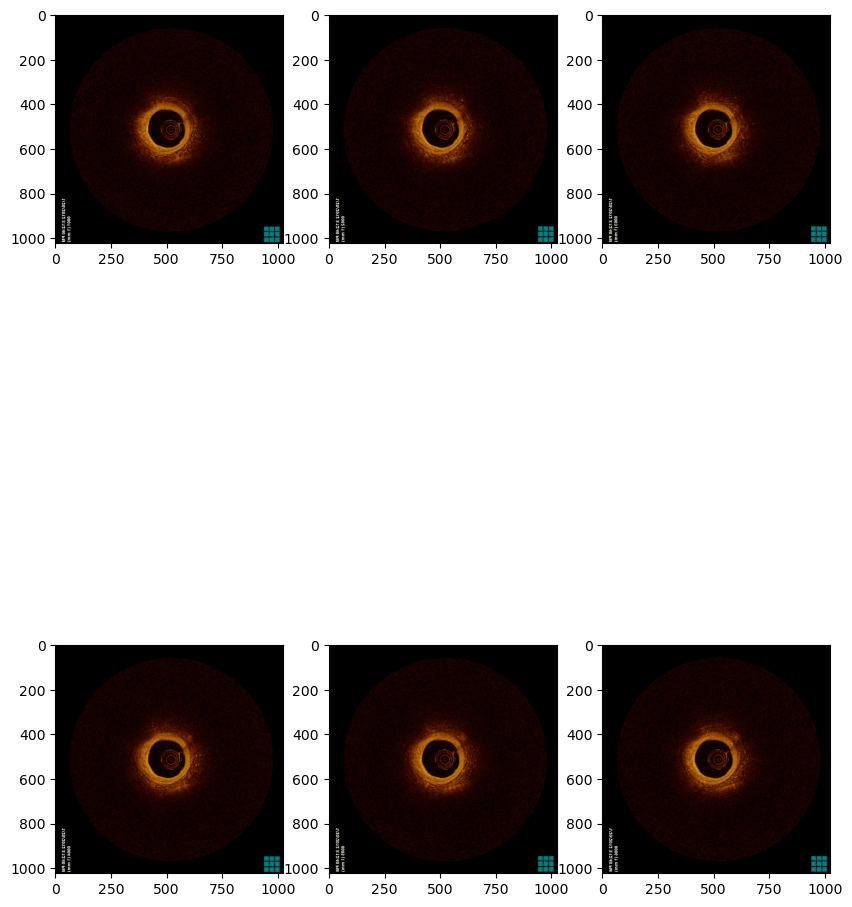

In [28]:
fig, axes = plt.subplots(2, 3, figsize=(10, 15))

for i, ax in enumerate(axes.flat):
    ax.imshow(translated_img[:,:,i])

plt.subplots_adjust()

In [29]:
out_fp = os.path.join(DATA_DIR, 'centered_image.npy')
np.save(out_fp, translated_img)

In [30]:
del img
del img_np
del translated_img